# Assignment 2

Welcome to the assignment for week 2.

## Task 2: Convolution and Canny edge detection

### Task 2.1: Convolution
Implement the convolution operation for 2-D images (i.e. no colors here, sorry).

In [1]:
# imports
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np

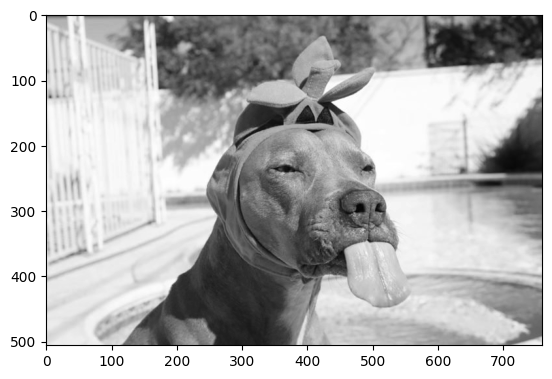

In [2]:
def conv2d(image, kernel):
    # Check if kernel is empty
    if not isinstance(kernel, np.ndarray) or kernel.size == 0:
        # Return the original image if kernel is empty
        return image
    
   
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    
  
    result = np.zeros_like(image)
    
  
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            result[i, j] = np.sum(region * kernel)
    
    return result

image = color.rgb2gray(io.imread('images/dog.jpg'))

plt.imshow(conv2d(image, []), cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show the results using your conv2d()-function.  (***RESULT***).

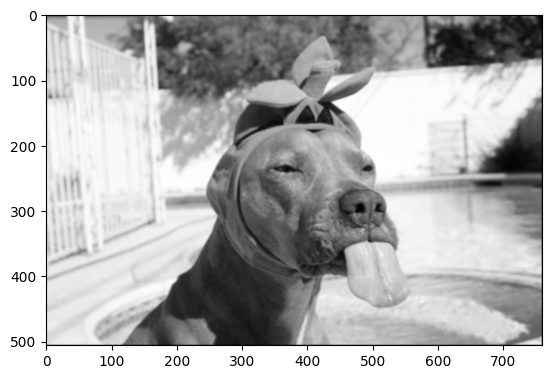

In [5]:
# code here
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    ax = np.arange(-size, size + 1)
    normal = 1 / (2.0 * np.pi * sigma**2)
    x_squared = ax[:, None] ** 2  
    y_squared = ax[None, :] ** 2  
    g = np.exp(-((x_squared + y_squared) / (2.0 * sigma**2))) * normal
    return g

size = 5
sigma = 1

kernel = gaussian_kernel(size, sigma)
convolved_image = conv2d(image, kernel)
plt.imshow(convolved_image, cmap='gray')

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

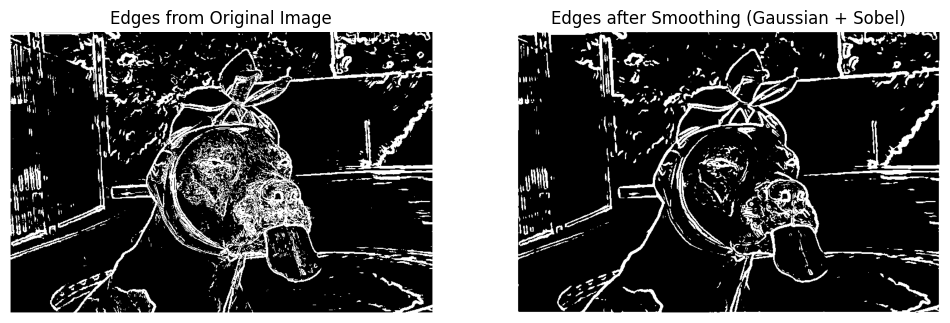

In [6]:
# code here

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
def sobel_edge_detection(image):
    """Applies the Sobel operator and returns the edge magnitude."""
    grad_x = conv2d(image, sobel_x)
    grad_y = conv2d(image, sobel_y)
    
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x) * 180 / np.pi
    return grad_magnitude, direction

def threshold_image(image, threshold):
    """Thresholds the image to create a binary edge map."""
    return (image > threshold).astype(np.float32)

t=0.25
edges_original,_= sobel_edge_detection(image)
thresholded_edges_original = threshold_image(edges_original, threshold=t)

edges_smoothed, direction= sobel_edge_detection(convolved_image)
thresholded_edges_smoothed = threshold_image(edges_smoothed, threshold=t)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.imshow(thresholded_edges_original, cmap='gray')
plt.title('Edges from Original Image')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(thresholded_edges_smoothed, cmap='gray')
plt.title('Edges after Smoothing (Gaussian + Sobel)')
plt.axis('off')

plt.show()

### Task 2.2: Canny Edge Detection

#### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices according to the lecture. Round the gradient directions to the 8-neighbor's directions. Display all intermediate ***RESULT***s!

(np.float64(-0.5), np.float64(759.5), np.float64(505.5), np.float64(-0.5))

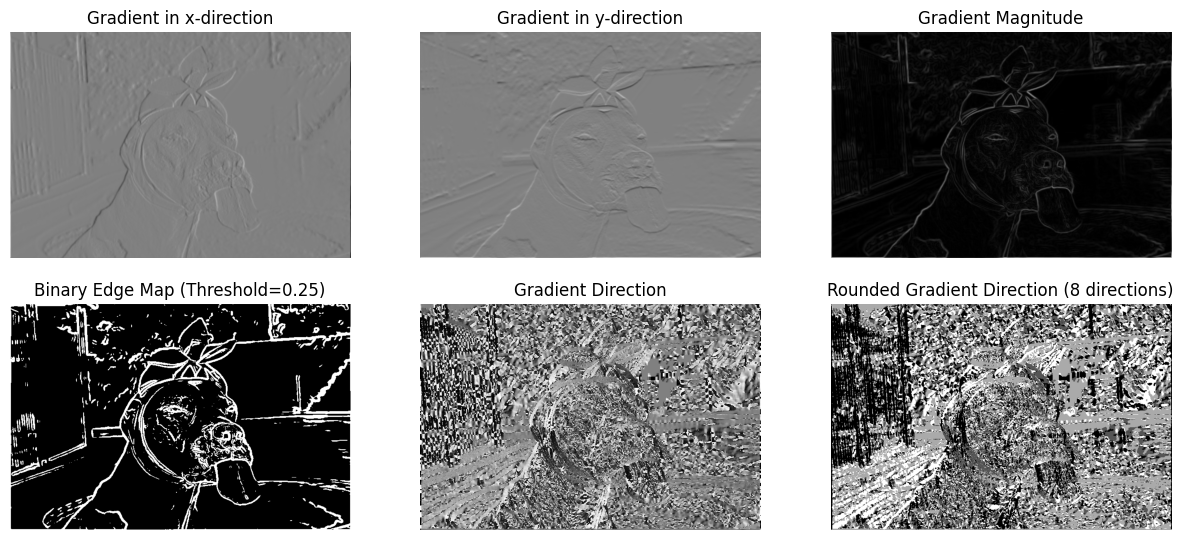

In [7]:
# code here
# 0°: For angles close to 0° (horizontal edges).
# 45°: For angles between 22.5° and 67.5° (diagonal edges).
# 90°: For angles between 67.5° and 112.5° (vertical edges).
# 135°: For angles between 112.5° and 157.5° (opposite diagonal edges).
def round_gradient_directions(angle):
    angle[angle < 0] += 180  
    rounded_angles = np.zeros_like(angle)
    
    # Rounding to nearest 8-neighbor direction (0°, 45°, 90°, or 135°)
    for i in range(angle.shape[0]):
        for j in range(angle.shape[1]):
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                rounded_angles[i, j] = 0
            elif (22.5 <= angle[i, j] < 67.5):
                rounded_angles[i, j] = 45
            elif (67.5 <= angle[i, j] < 112.5):
                rounded_angles[i, j] = 90
            elif (112.5 <= angle[i, j] < 157.5):
                rounded_angles[i, j] = 135

    return rounded_angles
size = 7
sigma = 1

kernel = gaussian_kernel(size, sigma)
convolved_image = conv2d(image, kernel)

grad_x = conv2d(convolved_image, sobel_x)
grad_y = conv2d(convolved_image, sobel_y)

grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
direction = np.arctan2(grad_y, grad_x) * 180 / np.pi
rounded_direction = round_gradient_directions(direction)

plt.figure(figsize=(15, 10))

plt.subplot(3, 3, 1)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient in x-direction')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient in y-direction')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(grad_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(thresholded_edges_smoothed, cmap='gray')
plt.title(f'Binary Edge Map (Threshold={t})')
plt.axis('off')


plt.subplot(3, 3, 5)
plt.imshow(direction, cmap='gray')
plt.title('Gradient Direction')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(rounded_direction, cmap='gray')
plt.title('Rounded Gradient Direction (8 directions)')
plt.axis('off')



#### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

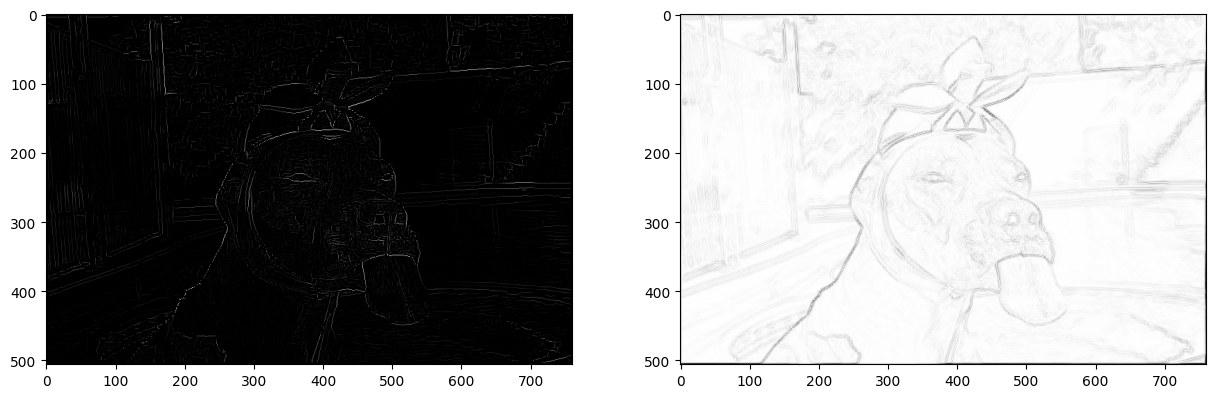

In [6]:
#2.b : Convert to thinned edge
def non_maximal_suppressor(grad_mag, angle) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(angle[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(angle[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(angle[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else:
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output

nms_image = non_maximal_suppressor(grad_magnitude, rounded_direction)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(nms_image, cmap='gray')
plt.subplot(2, 2, 2)
difference_image =  nms_image-edges_smoothed
plt.imshow(difference_image, cmap='gray')

#### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)

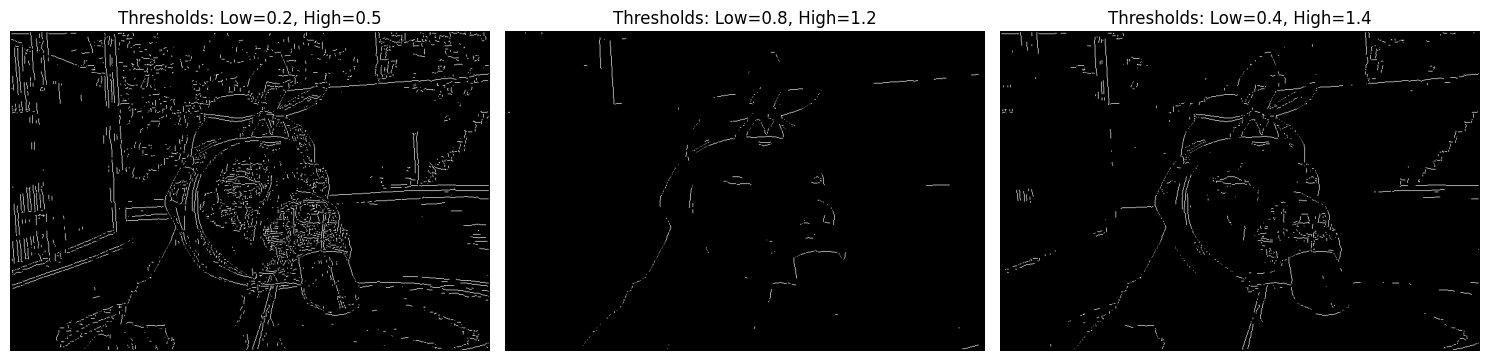

In [7]:
def threshold(img,highThreshold,lowThreshold):
    weak = 75
    strong = 255
    image_height, image_width = img.shape
    res = np.zeros((image_height,image_width))
    res[np.where(img >= highThreshold)] = strong
    res[np.where((img <= highThreshold) & (img >= lowThreshold))] = weak
    return res

def hysteresis(img):
    weak = 75
    strong = 255
    image_height, image_width = img.shape
   
    for i in range(1, image_height-1):
        for j in range(1, image_width-1):
            if (img[i,j] == weak):
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0

    return img

# using relative thresholds here:
threshold_pairs = [(0.20, 0.50), (0.80, 1.20), (0.40, 1.40)]


plt.figure(figsize=(15, 5))
for idx, (low_thresh, high_thresh) in enumerate(threshold_pairs, 1):
    thresh_img= threshold(nms_image, low_thresh, high_thresh)
    final_edges = hysteresis(thresh_img)
    
    plt.subplot(1, 3, idx)
    plt.imshow(final_edges, cmap='gray')
    plt.title(f'Thresholds: Low={low_thresh}, High={high_thresh}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Congratz, you made it! :)